In [1]:
import sys
sys.path.insert(0, './py_torch_trpo')
from baselines.common import set_global_seeds, tf_util as U
import gym
import roboschool
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
from base_line_model.TRPO_agent import TRPO_agent_new
from base_line_model.mlp import MlpPolicy_new
from baselines import logger

plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)

seed = 1
logger.configure()
U.make_session(num_cpu=16).__enter__()
set_global_seeds(seed)

Logging to /tmp/openai-2018-05-05-07-26-26-506556


In [2]:
class adversial_env(object):
    def __init__(self):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.ratio = 0.7
        self.threshold = np.array([ 0.14244403,  0.07706523,  0.00016789,  0.00789366,  0.02395424])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.score_list = []
        self.epi_list = []
        self.env.metadata
        self.true_state = []
        self.dev_state = []
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08 #np.abs(st[3])+0.2*np.abs(st[1])-0.08#
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        obs = np.clip(a,-1,1)*self.threshold*self.ratio + self.obsr
        self.dev_state.append(obs)
        self.true_state.append(self.obsr)
        
        ac = self.agent.act(obs)
        self.obsr, r, done, _ = self.env.step(ac)
        #print( np.clip(a,-1,1),np.clip(a,-1,1)*self.ratio)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done: ###################################
            self.first = False
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            
        
        final_r = self.reward(self.obsr)
        if done and self.epi_num < self.max_turn:
            final_r = 15 # terminal cost 
        
        self.total_score += final_r
        
        return self.obsr, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    

# define an adversary(new agent)

In [3]:
env2 = adversial_env()
class pargm(object):
    def __init__(self):
        self.timesteps_per_batch = 50000 # what to train on
        self.max_kl = 0.01
        self.cg_iters = 10
        self.gamma = 0.995
        self.lam =  0.97# advantage estimation
        self.entcoeff=0.0
        self.cg_damping=0.1
        self.vf_stepsize=1e-3
        self.vf_iters =5
        self.max_timesteps = 1e8
        self.max_episodes=0
        self.max_iters=0  # time constraint
        self.max_epi_avg = 1001
        self.callback=None


def policy_fn(name, ob_space, ac_space):
        return MlpPolicy_new(name=name, ob_space=ob_space, ac_space=ac_space,
            hid_size=128, num_hid_layers=2)
    
parg = pargm()
agn = TRPO_agent_new('pi1', env2, policy_fn, parg)
agn.restore('adversary')

[2018-05-05 07:26:26,602] Making new env: RoboschoolInvertedPendulum-v1


Init param sum 1.91204
INFO:tensorflow:Restoring parameters from adversary/data


[2018-05-05 07:26:27,817] Restoring parameters from adversary/data


# adversarial evaluation

In [4]:
env = adversial_env()
action = []
for i in range(1):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.action_ev(obs)
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-05-05 07:26:27,925] Making new env: RoboschoolInvertedPendulum-v1


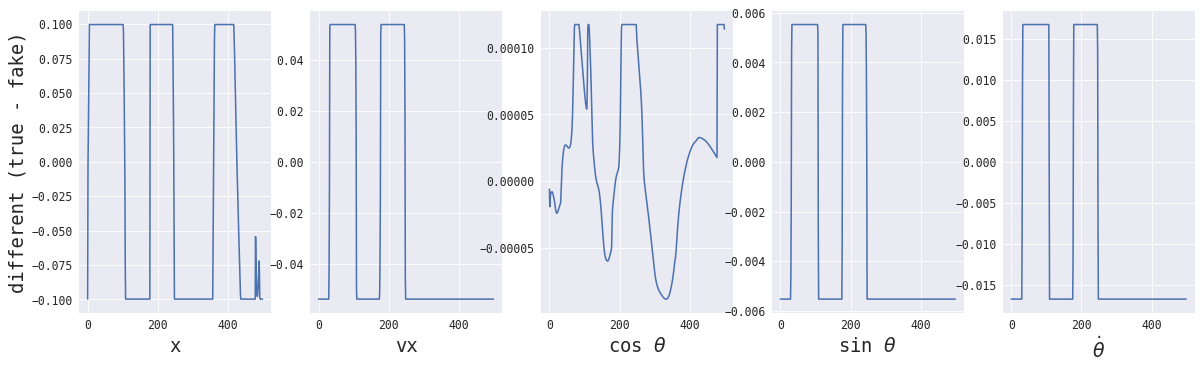

In [5]:
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
sensor_array1 = np.array(env.true_state)
sensor_array2 = np.array(env.dev_state)
sensor_array = sensor_array1 - sensor_array2

fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.plot(sensor_array[:,0])
plt.xlabel('x', fontsize=fon_size)
plt.ylabel('different (true - fake)', fontsize=fon_size)

plt.subplot(1,5,2)
plt.plot(sensor_array[:,1])
plt.xlabel('vx', fontsize=fon_size)

plt.subplot(1,5,3)
plt.plot(sensor_array[:,2])
plt.xlabel(r'cos $\theta$', fontsize=fon_size)

plt.subplot(1,5,4)
plt.plot(sensor_array[:,3])
plt.xlabel(r'sin $\theta$', fontsize=fon_size)

plt.subplot(1,5,5)
plt.plot(sensor_array[:,4])
plt.xlabel(r'$\dot \theta$', fontsize=fon_size)

plt.show()